<a href="https://colab.research.google.com/github/Gauravs41/Vasundhara/blob/master/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading Flicker 8k Dataset from kaggle
https://www.kaggle.com/ming666/flicker8k-dataset


In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d ming666/flicker8k-dataset

In [ ]:
!unzip flicker8k-dataset.zip

#Data Collection

Reading Flickr8k.token.txt file which contains imageIDs and its corresponding Captions

In [ ]:
def readTextFile(path):
  with open(path) as f:
    captions = f.read()
  return captions

In [ ]:
captions = readTextFile("/content/Flickr8k_text/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]  # -1 is to remove last entry which empty string.

In [ ]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

Dictionary to map each images with the list of captions

In [ ]:
descriptions = {}

# this is each discription -> "1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way ."
# so first we split with '\t' which gives imageID and its Caption
# imageID = 1000268201_693b08cb0e.jpg
# Caption = A child in a pink dress is climbing up a set of stairs in an entry way .
# so now remove '.jpg' from imageID, which is not needed.

for x in captions:
  first,second = x.split('\t')
  img_name = first.split('.')[0]

  # if image id is not present already
  if descriptions.get(img_name) is None:
    descriptions[img_name] = []

  #append caption to list
  descriptions[img_name].append(second)

In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

View Image

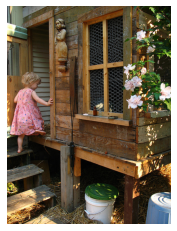

In [ ]:
IMG_PATH = '/content/Flickr8k_Dataset/Flicker8k_Dataset/'
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

#Data Cleaning

In [ ]:
import re

def clean_text(sentence):
  #convert to lowercase
  sentence = sentence.lower();
  #substitute that is not(^) belongs to a-z with space(" "), (removing punctuations and symbols (, . / @ # $ etc))
  sentence = re.sub("[^a-z]+"," ",sentence)

  #now we remove one letter word
  sentence = sentence.split()
  sentence = [s for s in sentence if len(s)>1 ]
  sentence = " ".join(sentence)
  return sentence

clean_text("A child in a pink dress is climbing up a set of stairs in an entry way")
  

'child in pink dress is climbing up set of stairs in an entry way'

In [ ]:
# clean all captions
for key,caption_list in descriptions.items():
  for i in range(len(caption_list)):
    caption_list[i] = clean_text(caption_list[i])

In [ ]:
# write the data into file
with open('descriptions.txt','w') as f:
  f.write(str(descriptions))

#Creating Vocab

In [ ]:
import json

# Load saved description.txt file 
descriptions = None
with open('descriptions.txt','r') as f:
  descriptions = f.read()

# but we need to load it as json 
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [ ]:
# create vocab which contains unique words for that we will use set
vocab = set()

for key in descriptions.keys():
  [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("vocab size: ",len(vocab))

vocab size:  8424


In [ ]:
#Counting all words in dictionary

total_words = []

for key in descriptions.keys():
  [total_words.append(i) for des in descriptions[key]  for i in des.split()]

print("total number of words: ", len(total_words))

total number of words:  373837


In [ ]:
import collections

# Calculate frequency of all words
counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(freq_cnt)

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [ ]:
# Filter words from the vocab according to certain threshlod frequency
# for that we sort dictionary(by converting into list using .items() because sorting done only on list) according to frequency

sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key = lambda x:x[1])

#filter
frequency = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>frequency]
total_words = [x[0] for x in sorted_freq_cnt]
print("total words in dictionary after cleaning: ",len(total_words))

total words in dictionary after cleaning:  1845


#Preparing Train/Test Data

In [ ]:
# in flicker trainImage.txt testImage.txt file contain train and test imageID
train_file_data = readTextFile('/content/Flickr8k_text/Flickr_8k.trainImages.txt')
test_file_data = readTextFile('/content/Flickr8k_text/Flickr_8k.testImages.txt')

In [ ]:
#split on new line and then remove ".jpg"
train = [row.split('.')[0] for row in train_file_data.split('\n')[:-1]]
test = [row.split('.')[0] for row in test_file_data.split('\n')[:-1]]

In [ ]:
#Prepare description for training data
# Tweak - add <startseq> and <endseq> token to all captions

train_descriptions = {}
for img_id in train:
  train_descriptions[img_id] = []
  for cap in descriptions[img_id]:
    cap_to_append = "startseq " + cap + " enqseq"
    train_descriptions[img_id].append(cap_to_append)

In [ ]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way enqseq',
 'startseq girl going into wooden building enqseq',
 'startseq little girl climbing into wooden playhouse enqseq',
 'startseq little girl climbing the stairs to her playhouse enqseq',
 'startseq little girl in pink dress going into wooden cabin enqseq']

#Transfer Learning


*   Images -> feature
*   Text -> feature



##Step 1 - Image Feature Extraction 

###Creating Model for Feature Extraction

In [ ]:
from keras.models import Model,load_model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3


# We are using Resnet50 with imagenet weights
model = InceptionV3(weights='imagenet', input_shape=(299,299,3))
model.summary()

96116736/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_27[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

In [ ]:
# We take output of "avg_pool (GlobalAveragePooling2 (None, 2048)" as our feature.
model_new = Model(model.input, (model.layers[-2]).output)

In [ ]:
# It accepting 4D tensor of dim(batch_size, 224,224,3) as input
model.input

In [ ]:
# Output dim will be (batch_size, 2048);
model.layers[-2].output

###Image Preprocessing

In [ ]:
import numpy as np

def preprocess_img(img):
  img = image.load_img(img,target_size=(299,299))
  img = image.img_to_array(img)

  # As we have seen our model is accepting 4D tensor, so we have to pass only 4D tensor with dim(batch_size, 224,224,3)
  # "expand_dims" exapands 3D image array to 4D tensor
  # image(224,224,3) to  tensor(batch_size,224,224,3) : here we will preprocess each images one by one so batch size will be 1.
  img = np.expand_dims(img,axis=0)

  # Normalization - different frameworks uses different type of Normalization
  img = preprocess_input(img)
  return img

In [ ]:
def encode_image(img):
  img = preprocess_img(img)

  # this will return predicted feature of image with dimesion of (1,2048) (for batch size = 1)
  feature_vector = model_new.predict(img)

  # We have to reshape 2D tensoor to 1D by slicing because, we just need scaler feature array which is dim(2048) 
  # for every imageID to one feature array
  feature_vector = feature_vector.reshape((-1))
  return feature_vector

In [ ]:
#Training Data

import time

start_t = time.time()
encoding_train = {}
IMG_PATH = '/content/Flickr8k_Dataset/Flicker8k_Dataset/'

for ix,img_id in enumerate(train):
  img_path = IMG_PATH + img_id + '.jpg'
  encoding_train[img_id] = encode_image(img_path)

  if ix % 100 == 0:
    print("Encoding in Process Time step :", ix)

end_t = time.time()
print("Total time taken : ",end_t - start_t)
#430s

In [ ]:
import pickle

with open("encoding_train_features.pkl","wb") as f:
  pickle.dump(encoding_train,f)

In [ ]:
#Test Data

import time

start_t = time.time()
encoding_test = {}
IMG_PATH = '/content/Flickr8k_Dataset/Flicker8k_Dataset/'

for ix,img_id in enumerate(test):
  img_path = IMG_PATH + img_id + '.jpg'
  encoding_test[img_id] = encode_image(img_path)

  if ix % 100 == 0:
    print("Encoding in Process Time step :", ix)

end_t = time.time()
print("Total time taken : ",end_t - start_t)
#69s

In [ ]:
with open("encoding_test_features.pkl","wb") as f:
  pickle.dump(encoding_test,f)

In [ ]:
import pickle

train_pkl = open('/content/encoding_train_features.pkl', 'rb')
encoding_train = pickle.load(train_pkl)

test_pkl = open('/content/encoding_test_features.pkl', 'rb')
encoding_test = pickle.load(test_pkl)

##Step 2 - Text Feature Extraction

###Caption Preprocessing

In [ ]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
  word_to_idx[word] = i + 1
  idx_to_word[i + 1] = word

In [ ]:
word_to_idx['startseq'] = len(total_words) + 1
idx_to_word[len(total_words) + 1] = 'startseq'

word_to_idx['endseq'] = len(total_words) + 2
idx_to_word[len(total_words) + 2] = 'endseq'

vocab_size = len(word_to_idx) + 1
print("Vocab size : ",vocab_size)

Vocab size :  1848


In [ ]:
max_len = 0

for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    max_len = max(max_len, len(cap.split()))

print(max_len)

35


###Word Embeddings

In [ ]:
!kaggle datasets download -d watts2/glove6b50dtxt
!unzip glove6b50dtxt.zip

In [ ]:
!kaggle datasets download -d incorpes/glove6b200d
!unzip glove6b200d.zip

In [ ]:
f = open("/content/glove.6B.200d.txt",encoding='utf8')

In [ ]:
embedding_index={}

for line in f:
  values = line.split()
  word = values[0]
  word_embedding = np.array(values[1:],dtype='float')
  embedding_index[word] = word_embedding

f.close()

In [ ]:
def get_embedding_matrix(embedding_index):
  # emb_dim = 50
  emb_dim = 200
  matrix = np.zeros((vocab_size,emb_dim))

  for word,idx in word_to_idx.items():
      embedding_vector = embedding_index[word]
      if embedding_index is not None:
          matrix[idx] = embedding_vector

      return matrix

In [ ]:
embedding_matrix = get_embedding_matrix(embedding_index)
embedding_matrix.shape

(1848, 200)

## Step 3 - Data Loader

In [ ]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
  X1,X2,Y = [],[],[]
  
  n=0
  while True:
    for key, desc_list in train_descriptions.items():
        photo = encoding_train[key]
        n+=1
        for desc in desc_list:
            seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
            for i in range(1,len(seq)):
                xi = seq[0:i]
                yi = seq[i]

                #0 denotes padding word
                xi = pad_sequences([xi],maxlen=max_len, padding='post', value=0)[0]
                yi = to_categorical([yi], num_classes=vocab_size)[0]

                X1.append(photo)
                X2.append(xi)
                Y.append(yi)
            
        if n==batch_size:
            yield  [np.array(X1), np.array(X2)], np.array(Y)
            X1,X2,Y = [],[],[]
            n = 0

#Model Architecture

In [ ]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.5)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [ ]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=200,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.5)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [ ]:
model.summary()

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 35, 200)      369600      input_29[0][0]                   
__________________________________________________________________________________________________
dropout_25 (Dropout)            (None, 2048)         0           input_28[0][0]                   
______________________________________________________________________________________

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

#Training Model

In [ ]:
# model.optimizer.lr = 0.001

epochs = 10
batch_size = 3
steps = len(train_descriptions)//batch_size

In [ ]:
for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('model_weights1/model_'+str(i)+'.h5')

1199/2000 [================>.............] - ETA: 19s - loss: 5.1147

KeyboardInterrupt: ignored

In [ ]:
with open("/content/encoding_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [ ]:
model = load_model('./model_weights1/model_5.h5')

In [ ]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

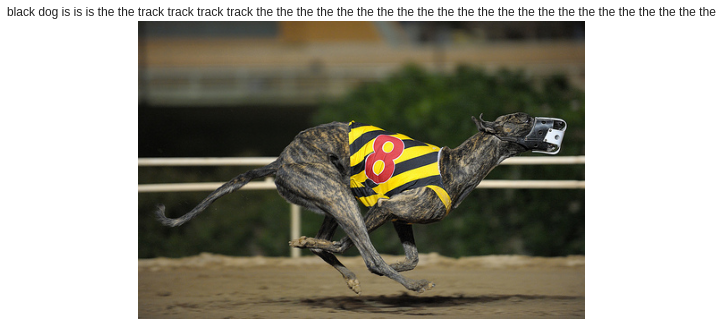

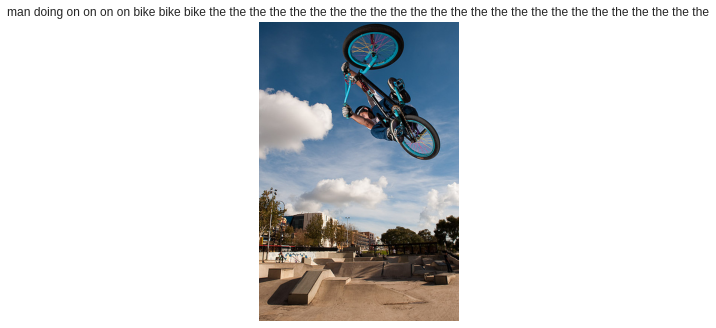

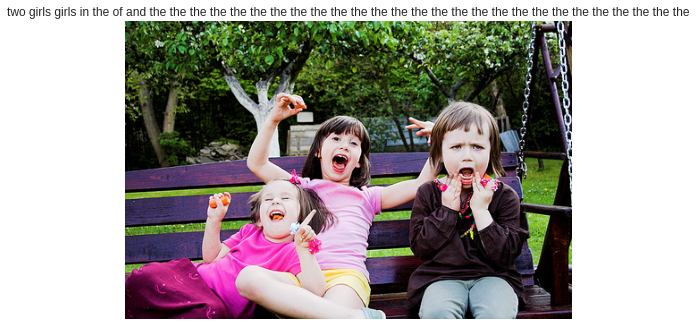

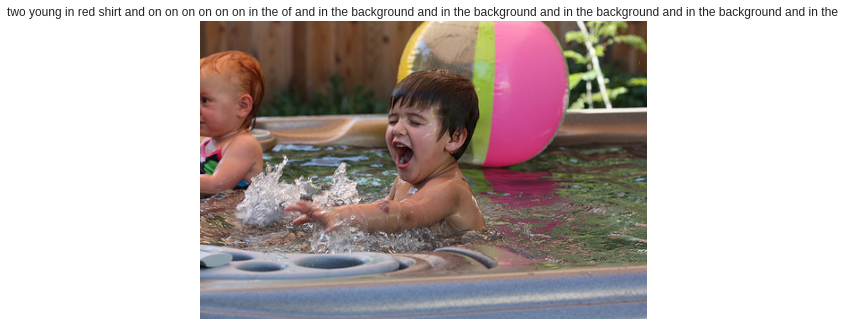

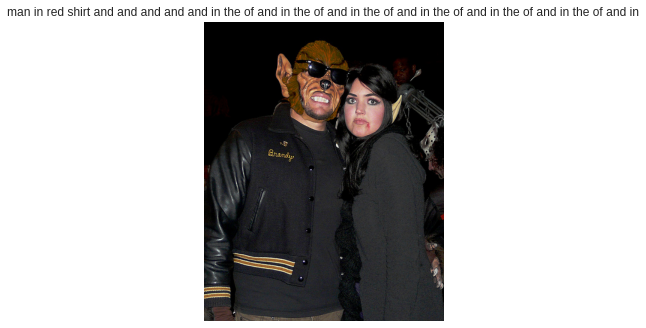

In [ ]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(5):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("/content/Flickr8k_Dataset/Flicker8k_Dataset/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()